# Block Model using `SimPEG`



Note on environment: running `simulation` branch of SimPEG

In [1]:
# core python libraries we rely on
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# SimPEG ecosystem 
import discretize
from discretize.utils import mkvc
from SimPEG.electromagnetics import frequency_domain as fdem
from pymatsolver import Pardiso
import ipywidgets
%load_ext memory_profiler

## load the model and survey

In [2]:
# 1D background
depth = [0., -600, -850, -3150]
res1d = [1e8, 0.3, 1, 2, 1000]
aniso = [1, 1, 1, np.sqrt(2), 1]

# Define dimensions of the three blocks [x1, x2, y1, y2, z1, z2]
block1 = [ -500,  500, -4000, 4000,  -1600, -850]
block2 = [    0, 5000, -3000,    0,  -1850, -1600]
block3 = [-5000,    0,     0, 3000, -2900, -1600]

# Resistivities Block 1, 2, and 3
resistivities = [10, 100, 500]

In [3]:
ds = xr.load_dataset('../block_model_and_survey.nc', engine='h5netcdf')

In [4]:
hx, hy, hz = ds.attrs['hx'], ds.attrs['hy'], ds.attrs['hz']
x0 = ds.attrs['x0']
mesh_model = discretize.TensorMesh([hx, hy, hz], x0=x0)

mesh_model

TensorMesh: 288 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x      6    -10,000.00     10,000.00    500.00  5,000.00    9.00
   y      6    -10,000.00     10,000.00  1,000.00  6,000.00    6.00
   z      8     -3,400.00        500.00    250.00  1,050.00    4.20

In [5]:
resh_bg, resv_bg = ds.attrs['resh_bg'], ds.attrs['resv_bg']
resh_tg, resv_bg = ds.attrs['resh_tg'], ds.attrs['resv_tg']

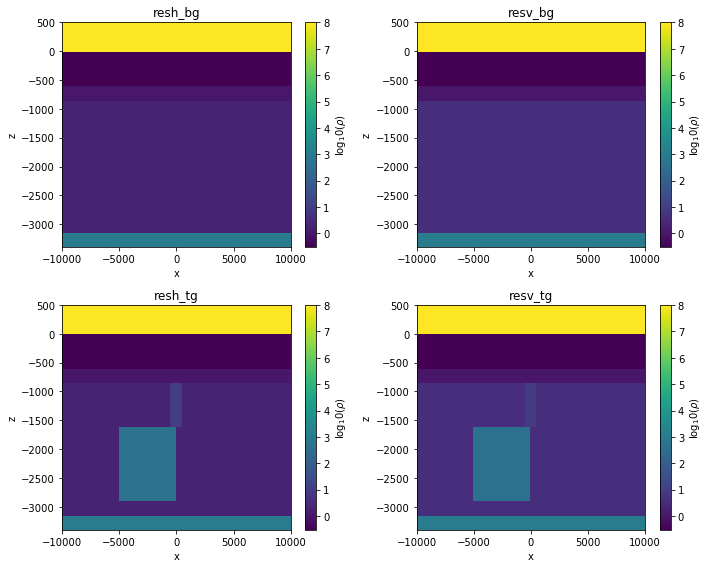

In [6]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

for a, m in zip(ax.flatten(), ['resh_bg', 'resv_bg', 'resh_tg', 'resv_tg']):
    cb = plt.colorbar(
        mesh_model.plotSlice(np.log10(ds.attrs[m]), ax=a, normal='Y')[0], ax=a
    )
    a.set_title(m)
    cb.set_label("log$_10$($\\rho$)")

plt.tight_layout()

In [7]:
# Get Survey
src = ds.attrs['src']
strength = ds.attrs['strength']
freq = ds.attrs['freq']
rec_x = ds.x.data[::2]
rec_y = ds.attrs['rec_y']
rec_z = ds.attrs['rec_z'] - 0.1
rx_locs = discretize.utils.ndgrid([rec_x, rec_y, np.r_[rec_z]])

# Get source center (for meshing)
src_c = np.mean(src.reshape(-1, 2), 1)
print(src)

[-100.  100.    0.    0. -550. -550.]


In [8]:
print(
    f"skin depth: {503/np.sqrt(freq/np.unique(resh_bg))}"
)

skin depth: [2.75504446e+02 5.03000000e+02 7.11349422e+02 1.59062566e+04
 5.03000000e+06]


## create a computational mesh

In [9]:
src[2:4]

array([0., 0.])

In [10]:
# use the same discretization and domain extent in each dimension
dx, dy, dz = 100, 200, 50 
domain_x, domain_y, domain_z = 3e4, 2e4, 4e4

nbmcx = 2**int(np.round(np.log(domain_x/dx)/np.log(2.)))
nbmcy = 2**int(np.round(np.log(domain_y/dy)/np.log(2.)))
nbmcz = 2**int(np.round(np.log(domain_z/dz)/np.log(2.)))

print(nbmcx, nbmcy, nbmcz)

npad_x = 6
npad_y = 6
npad_z_above = 10
npad_z_below = 2

pf = 2

# define the base mesh
mesh = discretize.TreeMesh(
    [
        [(dx, npad_x, -pf), (dx, nbmcx-npad_x*2), (dx, npad_x, pf)], 
        [(dy, npad_y, -pf), (dy, nbmcy-npad_y*2), (dy, npad_y, pf)], 
        [(dz, npad_z_below, -pf), (dz, nbmcz-npad_z_above-npad_z_below), (dz, npad_z_above, pf)]
    ]
)

mesh.x0 = np.r_[
    -np.sum(mesh.h[0])/2., -np.sum(mesh.h[1])/2., -np.sum(mesh.h[2][:nbmcz-npad_z_above])
]
# coarsen mesh outside of core domain


# refine around the layers 
xrefine = domain_x*np.r_[-1, 1]
yrefine = domain_y*np.r_[-1, 1]

for d in depth: 
    xr, yr, zr = np.meshgrid(xrefine, yrefine, np.r_[d])
    surface_refine = np.c_[mkvc(xr), mkvc(yr), mkvc(zr)]
    mesh = discretize.utils.refine_tree_xyz(
        mesh, surface_refine, 
        octree_levels=[1, 1], method="surface", finalize=False
    )

# refine around the sources and receivers
xr, yr, zr = np.meshgrid(src[0:2], src[2] + dy/2*np.r_[-1, 1], src[4] + dz/2*np.r_[-1, 1]) 
src_refine = np.c_[mkvc(xr), mkvc(yr), mkvc(zr)]
mesh = discretize.utils.refine_tree_xyz(
    mesh, src_refine, 
    octree_levels=[2, 2, 1], method="box", finalize=False
)

mesh = discretize.utils.refine_tree_xyz(
    mesh, rx_locs, 
    octree_levels=[3, 2, 1], method="radial", finalize=False
)

# refine around the blocks
for b in [block1, block2, block3]:
    for xb, yb, zb in zip(
        [b[0], b[1], b[0:2], b[0:2], b[0:2], b[0:2]], # x
        [b[2:4], b[2:4], b[2], b[3], b[2:4], b[2:4]], # y
        [b[4:6], b[4:6], b[4:6], b[4:6], b[4], b[5]]  # z
    ):
        if not isinstance(xb, list):
            xb = xb + 2*dx*np.r_[-1, 1]
        elif not isinstance(yb, list): 
            yb = yb + 2*dy*np.r_[-1, 1]
        elif not isinstance(zb, list): 
            zb = zb + 2*dz*np.r_[-1, 1]
            
        xr, yr, zr = np.meshgrid(xb, yb, zb) 
        surface_refine = np.c_[mkvc(xr), mkvc(yr), mkvc(zr)]
        mesh = discretize.utils.refine_tree_xyz(
            mesh, surface_refine, 
            octree_levels=[1, 1, 1],
            method="box", finalize=False
        )

mesh.finalize()

256 128 1024


In [11]:
print(mesh.nC)

413975


In [12]:
print(np.any(mesh.gridEx[:, 2] == -550.))

True


(<matplotlib.cm.ScalarMappable at 0x130990208>,)

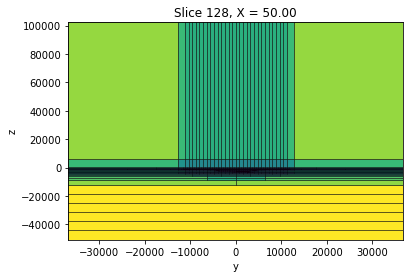

In [13]:
fig, ax = plt.subplots(1, 1)
mesh.plotSlice(np.log10(mesh.vol), normal='x', grid=True, ax=ax)
# ax.set_xlim([-10000, 10000])
# ax.set_ylim([-4000, 100])

In [14]:
def plot_mesh(normal="Y", ind=1024, xmin=-10000, xmax=10000, ymin=-4000, ymax=100):
    fig, ax = plt.subplots(1, 1)
    mesh.plotSlice(np.log10(mesh.vol), normal=normal, grid=True, ax=ax, ind=ind)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])

In [15]:
max_h = np.max([len(h) for h in mesh.h])
ipywidgets.interact(
    plot_mesh,
    normal=ipywidgets.ToggleButtons(options=["X", "Y", "Z"], value="Y"),
    ind=ipywidgets.IntSlider(min=0, max=max_h, value=int(len(mesh.h[1])/2)),
    xmin=ipywidgets.FloatText(value=-domain_x),
    xmax=ipywidgets.FloatText(value=domain_x),
    ymin=ipywidgets.FloatText(value=-4000),
    ymax=ipywidgets.FloatText(value=100)
)

interactive(children=(ToggleButtons(description='normal', index=1, options=('X', 'Y', 'Z'), value='Y'), IntSli…

<function __main__.plot_mesh(normal='Y', ind=1024, xmin=-10000, xmax=10000, ymin=-4000, ymax=100)>

In [16]:
rec_z

-600.1

### put the model on the computational mesh

In [17]:
rhoh_back = res1d[0]*np.ones(mesh.nC)
rhov_back = res1d[0]*np.ones(mesh.nC)

In [18]:
for r, a, d in zip(res1d[1:], aniso, depth):
    inds = mesh.gridCC[:, 2] <= d + dz/2
    rhoh_back[inds] = r
    rhov_back[inds] = r*a**2

In [19]:
rhoh_t = rhoh_back.copy()
rhov_t = rhov_back.copy()

In [20]:
for r, b in zip(resistivities, [block1, block2, block3]):
    inds = (
        (mesh.gridCC[:, 0] >= b[0]) & (mesh.gridCC[:, 0] <= b[1]) &
        (mesh.gridCC[:, 1] >= b[2]) & (mesh.gridCC[:, 1] <= b[3]) &
        (mesh.gridCC[:, 2] >= b[4]) & (mesh.gridCC[:, 2] <= b[5])
    )
    rhoh_t[inds] = r
    rhov_t[inds] = r

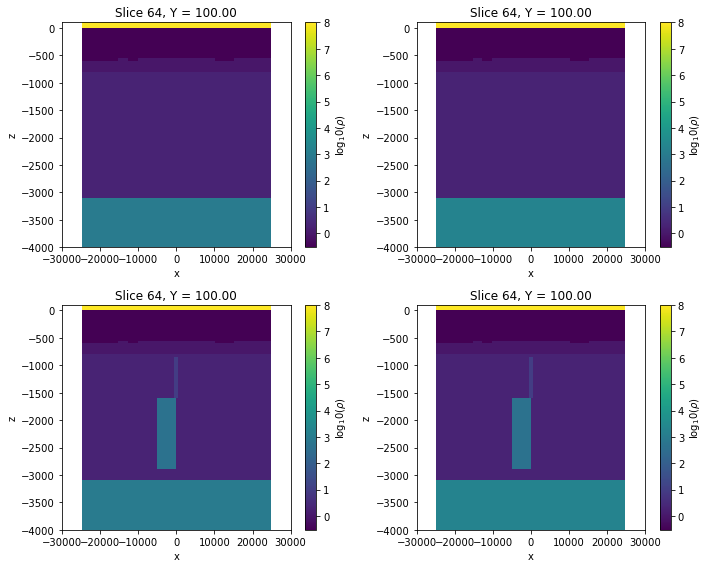

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8))

for a, m in zip(ax.flatten(), [rhoh_back, rhov_back, rhoh_t, rhov_t]):
    cb = plt.colorbar(
        mesh.plotSlice(np.log10(m), ax=a, normal='Y')[0], ax=a
    )
    cb.set_label("log$_10$($\\rho$)")
    a.set_xlim(domain_x*np.r_[-1, 1])
    a.set_ylim([-4000, 100])

plt.tight_layout()

In [22]:
rho_back = np.vstack([rhoh_back, rhoh_back, rhov_back]).T
rho_t = np.vstack([rhoh_t, rhoh_t, rhov_t]).T

## set up the frequency domain simulation

In [23]:
rx_re = fdem.receivers.Point_e(locations=rx_locs, orientation="x", component="real")
rx_im = fdem.receivers.Point_e(locations=rx_locs, orientation="x", component="imag")

In [24]:
print(np.unique(mesh.gridEx[:, 1]))

[-36800. -24000. -17600. -14400. -12800. -12000. -11600. -11400. -11200.
 -11000. -10800. -10600. -10400. -10200. -10000.  -9800.  -9600.  -9400.
  -9200.  -9000.  -8800.  -8600.  -8400.  -8200.  -8000.  -7800.  -7600.
  -7400.  -7200.  -7000.  -6800.  -6600.  -6400.  -6200.  -6000.  -5800.
  -5600.  -5400.  -5200.  -5000.  -4800.  -4600.  -4400.  -4200.  -4000.
  -3800.  -3600.  -3400.  -3200.  -3000.  -2800.  -2600.  -2400.  -2200.
  -2000.  -1800.  -1600.  -1400.  -1200.  -1000.   -800.   -600.   -400.
   -200.      0.    200.    400.    600.    800.   1000.   1200.   1400.
   1600.   1800.   2000.   2200.   2400.   2600.   2800.   3000.   3200.
   3400.   3600.   3800.   4000.   4200.   4400.   4600.   4800.   5000.
   5200.   5400.   5600.   5800.   6000.   6200.   6400.   6600.   6800.
   7000.   7200.   7400.   7600.   7800.   8000.   8200.   8400.   8600.
   8800.   9000.   9200.   9400.   9600.   9800.  10000.  10200.  10400.
  10600.  10800.  11000.  11200.  11400.  11600.  1

In [25]:
src_x = np.zeros(mesh.nEx)
src_inds = (
    (mesh.gridEx[:, 0] >= src[0] - 1) & (mesh.gridEx[:, 0] <= src[1] + 1) &
    (mesh.gridEx[:, 1] >= src[2] - 1) & (mesh.gridEx[:, 1] <= src[3] + 1) &
    (mesh.gridEx[:, 2] >= src[4] - 1) & (mesh.gridEx[:, 2] <= src[5] + 1) 
)
src_x[src_inds] = 1
print(src_inds.nonzero())

src_vec = strength * np.hstack([
    src_x, np.zeros(mesh.nEy), np.zeros(mesh.nEz)
])
source = fdem.sources.RawVec_e(s_e=src_vec, freq=freq, receiver_list=[rx_re, rx_im])

(array([147637, 148558]),)


In [26]:
np.nonzero(src_vec)

(array([147637, 148558]),)

In [27]:
np.unique(mesh.gridEx[src_inds, 0]), np.unique(mesh.gridEx[src_inds, 1]), np.unique(mesh.gridEx[src_inds, 2])

(array([-50.,  50.]), array([0.]), array([-550.]))

In [28]:
survey = fdem.Survey([source])

In [29]:
sim_back = fdem.Simulation3DElectricField(mesh=mesh, solver=Pardiso, survey=survey, rho=rho_back)
sim_t = fdem.Simulation3DElectricField(mesh=mesh, solver=Pardiso, survey=survey, rho=rho_t)

In [30]:
%%time
mem_back = %memit -o fields_back = sim_back.fields()
ram_back = f"{(mem_back.mem_usage[0] - mem_back.baseline)/1024:.3f} GiB"
print(f"memory usage: {ram_back}")

peak memory: 7657.02 MiB, increment: 6345.54 MiB
memory usage: 6.197 GiB
CPU times: user 12min 43s, sys: 6min 34s, total: 19min 18s
Wall time: 20min 3s


In [31]:
%%time
mem_t = %memit -o fields_t = sim_t.fields()
ram_t = f"{(mem_t.mem_usage[0] - mem_t.baseline)/1024:.3f} GiB"
print(f"memory usage: {ram_t}")

peak memory: 7212.64 MiB, increment: 7013.12 MiB
memory usage: 6.849 GiB
CPU times: user 11min 28s, sys: 5min 38s, total: 17min 6s
Wall time: 20min 9s


In [32]:
d_back = sim_back.dpred(f=fields_back)
d_t = sim_t.dpred(f=fields_t)

In [33]:
def get_data_lines(fields):
    
    data = []
    
    x_inds = (mesh.gridEx[:, 0] >= rec_x.min() - 1) & (mesh.gridEx[:, 0] <= rec_x.max() + 1)
    z_inds = (mesh.gridEx[:, 2] >= rec_z - 1) & (mesh.gridEx[:, 2] <= rec_z + 1)
    
    for y in rec_y: 
        y_inds = (mesh.gridEx[:, 1] >= y - 1) & (mesh.gridEx[:, 1] <= y + 1)
        inds_x = x_inds & y_inds & z_inds
        inds = np.hstack([inds_x, np.zeros(mesh.nEy, dtype=bool), np.zeros(mesh.nEz, dtype=bool) ])
        
        data.append(fields[:, "e"][inds])
    
    x = mesh.gridEx[inds_x, 0]
    return x, data   

In [34]:
x, data_back = get_data_lines(fields_back)
x, data_t = get_data_lines(fields_t)

In [35]:
# reshape data to desired shape

def get_data_lines(data): 
    d_re = data[:rx_locs.shape[0]]
    d_im = data[rx_locs.shape[0]:]

    d_line1 = np.vstack([d_re[:101], d_im[:101]]).T
    d_line2 = np.vstack([d_re[101:202], d_im[101:202]]).T
    d_line3 = np.vstack([d_re[202:], d_im[202:]]).T
    
    return [d_line1, d_line2, d_line3]

data_back_lines = get_data_lines(d_back)
data_t_lines = get_data_lines(d_t)

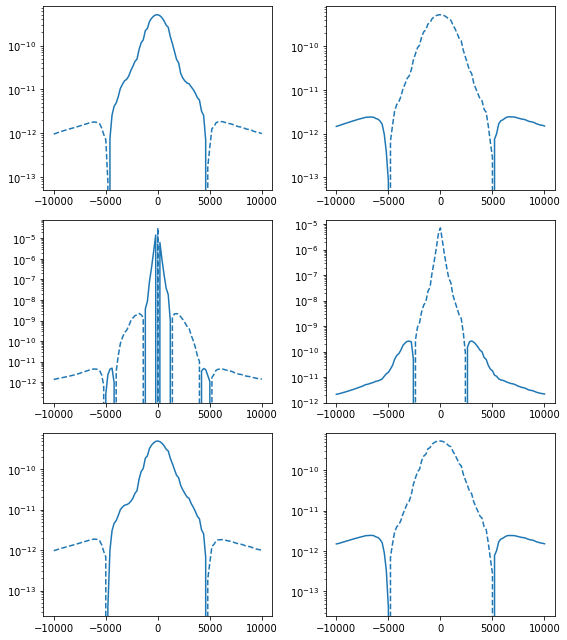

In [36]:
fig, ax = plt.subplots(3, 2, figsize=(8, 9))

# for i, d in enumerate(data_back):
#     for j, comp in enumerate(["real", "imag"]):
#         ax[i, j].semilogy(x, getattr(d, comp), "C1-")
#         ax[i, j].semilogy(x, -getattr(d, comp), "C1--")

for i, d in enumerate(data_back_lines):
    for j, comp in enumerate(["real", "imag"]):
        ax[i, j].semilogy(rec_x, d[:, j], "C0-")
        ax[i, j].semilogy(rec_x, -d[:, j], "C0--")

plt.tight_layout()

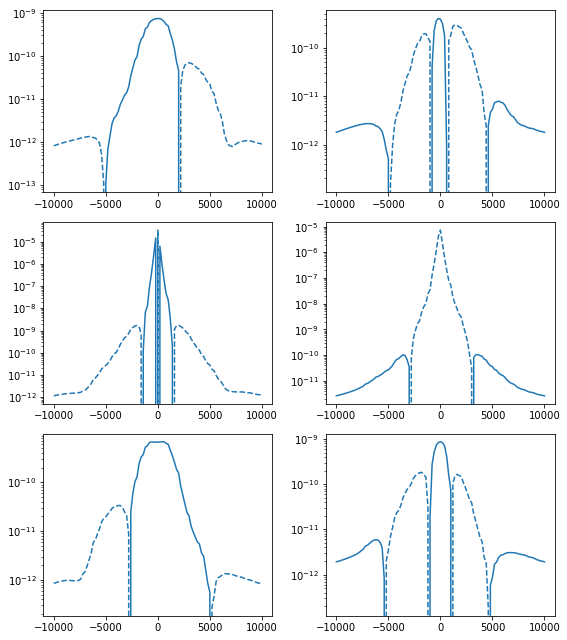

In [37]:
fig, ax = plt.subplots(3, 2, figsize=(8, 9))

for i, d in enumerate(data_t_lines):
    for j, comp in enumerate(["real", "imag"]):
        ax[i, j].semilogy(rec_x, d[:, j], "C0-")
        ax[i, j].semilogy(rec_x, -d[:, j], "C0--")

plt.tight_layout()

In [38]:
def extract_lines(name):
    import xarray as xr
    inp = xr.load_dataset(name, engine='h5netcdf')
    out = np.stack([
        inp.line_1[::2]+1j*inp.line_1[1::2],
        inp.line_2[::2]+1j*inp.line_2[1::2],
        inp.line_3[::2]+1j*inp.line_3[1::2],
    ]).T
    return out

epm_1d = extract_lines('../results/layered_empymod.nc')

In [39]:
epm_1d.shape

(101, 3)

In [40]:
def get_pos_neg(resp, off, min_off):
    """Separate positive and negative values, enforce min_off."""
    resp_pos = np.array([x if x > 0 else np.nan for x in resp])
    resp_neg = np.array([-x if x < 0 else np.nan for x in resp])

    resp_pos[off < min_offset] = np.nan
    resp_neg[off < min_offset] = np.nan

    return resp_pos, resp_neg

In [41]:
# Calculate error
error = {}
spg_data = np.vstack([d[:, 0] + 1j*d[:, 1] for d in data_back_lines]).T
for name, data in zip(['SimPEG'], [spg_data]):
    rerr = np.clip(100*abs((epm_1d.real-data.real)/epm_1d.real), 0.01, 100)
    ierr = np.clip(100*abs((epm_1d.imag-data.imag)/epm_1d.imag), 0.01, 100)
    error[name] = rerr + 1j*ierr

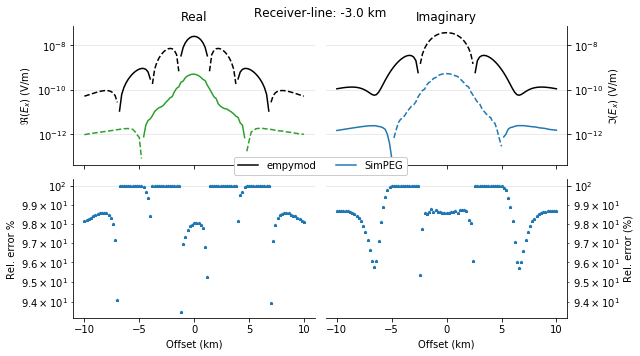

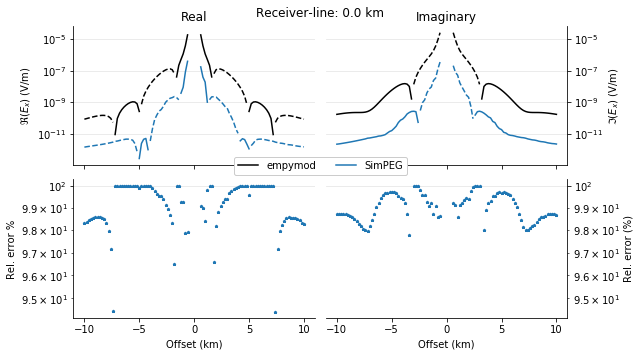

In [42]:
marker = ['*', 'v', '^', 'o']
min_offset = 500

for iy, y in enumerate(rec_y[:2]):
    
    # Get offset
    off = np.sqrt(rec_x**2 + y**2)

    plt.figure(figsize=(9, 5))

    # # Real
    ax1 = plt.subplot(221)
    plt.title('Real')

    resp_pos, resp_neg = get_pos_neg(epm_1d[:, iy].real, off, min_offset)
    plt.plot(rec_x/1e3, resp_pos, 'k-', label='empymod')
    plt.plot(rec_x/1e3, resp_neg, 'k--')
    
    resp_pos, resp_neg = get_pos_neg(spg_data[:, iy].real, off, min_offset)
    plt.plot(rec_x/1e3, resp_pos, f'C{i}-', ms=3, label="SimPEG")
    plt.plot(rec_x/1e3, resp_neg, f'C{i}--', ms=3)


    plt.ylabel(r'$\Re(E_x)$ (V/m)')
    ax1.set_xticklabels([])
    plt.grid(axis='y', c='0.9')


    # # Real Error
    ax2 = plt.subplot(223)

    for i, name in enumerate(error.keys()):
        error[name][off < min_offset, iy] = np.nan + 1j*np.nan
        plt.plot(rec_x/1e3, error[name][:, iy].real, f'C{i}{marker[i]}', ms=3)

    plt.yscale('log')
    plt.xlim(ax1.get_xlim())
    plt.ylabel('Rel. error %')
#     plt.ylim([8e-3, 120])
#     plt.yticks([0.01, 0.1, 1, 10, 100], ('0.01', '0.1', '1', '10', '100'))
    plt.grid(axis='y', c='0.9')
    plt.xlabel('Offset (km)')


    # # Imaginary
    ax3 = plt.subplot(222, sharey=ax1)
    plt.title('Imaginary')

    resp_pos, resp_neg = get_pos_neg(epm_1d[:, iy].imag, off, min_offset)
    plt.plot(rec_x/1e3, resp_pos, 'k-', label='empymod')
    plt.plot(rec_x/1e3, resp_neg, 'k--')
    
    resp_pos, resp_neg = get_pos_neg(spg_data[:, iy].imag, off, min_offset)
    plt.plot(rec_x/1e3, resp_pos, f'C{i}-', ms=3, label="SimPEG")
    plt.plot(rec_x/1e3, resp_neg, f'C{i}--', ms=3)
    
    plt.yscale('log')
    plt.ylabel(r'$\Im(E_x)$ (V/m)')

    ax3.set_xticklabels([])
    ax3.yaxis.tick_right()
    ax3.yaxis.set_label_position("right")
    plt.grid(axis='y', c='0.9')


    # # Imaginary Error
    ax4 = plt.subplot(224, sharey=ax2)

    for i, name in enumerate(error.keys()):
        plt.plot(rec_x/1e3, error[name][:, iy].imag, f'C{i}{marker[i]}', ms=3)

    # Legend
    plt.plot(0, -1, 'k', label='empymod')
    for i, name in enumerate(error.keys()):
        plt.plot(0, -1, f'C{i}', label=name)
        
    plt.yscale('log')
    plt.xlim(ax1.get_xlim())
    plt.xlabel('Offset (km)')
    plt.ylabel('Rel. error (%)')
#     plt.ylim([8e-3, 120])
#     plt.yticks([0.01, 0.1, 1, 10, 100], ('0.01', '0.1', '1', '10', '100'))
    ax4.yaxis.tick_right()
    ax4.yaxis.set_label_position("right")
    plt.grid(axis='y', c='0.9')

    # Switch off spines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax3.spines['top'].set_visible(False)
    ax3.spines['left'].set_visible(False)
    ax4.spines['top'].set_visible(False)
    ax4.spines['left'].set_visible(False)

    plt.tight_layout()
    plt.legend(loc=2, ncol=2, bbox_to_anchor=(-0.4, 1.2), framealpha=1)
    
    #plt.savefig(f'../manuscript/figures/results-layered-{int(y/1e3)}.pdf', bbox_inches='tight')
    plt.suptitle(f'Receiver-line: {y/1e3} km')
    plt.show()